## Molybdän-Spektrum

In [7]:
data1a = pd.read_csv("255\\1a_MoSpek_LiF.txt", sep="\t", decimal=',', header=None)
# display(data1a)

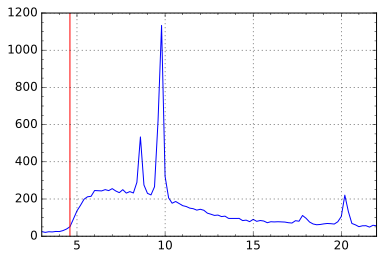

In [20]:
figure()
plot(data1a.iloc[:,0],data1a.iloc[:,1])
xlim((3,22))
# yscale('log')
minorticks_on()
axvline(x=4.6, color='r')
grid()
show()

## $K_{\alpha}$ und $K_{\beta}$